In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae

In [5]:
# load libraries and set plot parameters

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = "serif"
# plt.rcParams['font.serif'] = "cm"
# plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"

# Table of Contents

1. [Introduction](#intro)
1. [Models](#models)
1. [Metrics](#metrics)
1. [Data collection](#data_collection)
1. [Data analysis](#data_analysis)

<a id="intro"></a>
# Introduction

Have you ever complained about the weatherman failing to predict the weather correctly?

That's the question we aim to answer here: how reliable are the weather forecasts?

To do so we compare the accuracy of different weather models ranging from a naive approach to sophisticated meteorological models.

The scope of this analysis is restricted to the **temperature** in five locations around the world, namely:

- London
- Madrid
- Sydney
- New York
- Sao Paulo

<a id="models"></a>
# Models


### Naive forecast

Consists in assuming that the next value is the same as the one of the last period.

The tricky part is to identify what the last value is. For instance, if we measure the temperature
every 3 hours and we want to predict the temperature today at 3pm, what is the last value: today's temperature at 12pm, yesterday's temperature at 3pm or maybe last year's temperature on the same day at 3pm?


### Average values

Following with the previous example, we could use the average of the temperature over the last 20
years on the same day at 3pm


### Meteorological models

Provided by [OpenWeather](https://openweathermap.org/technology)

<a id="metrics"></a>
# Metrics

Metrics are used to evaluate the accuracy of the models' predictions when compared to the actual values.


## Mean absolute scaled error (MASE)

Mean absolute scaled error is a measure of the precision of a model compared to the naive forecast.

It is calculated as the mean absolute error of the forecast values predicted by the model divided by the mean absolute error of the naive forecast.

Values greater than one indicate that the naive method performs better than the more sophisticated forecast methods.

### Example

If $t^1$ is the 1-day forecast made on _2020-11-22 18:00_ for _2020-11-23 18:00_, the naive forecast is the actual temperature on _2020-11-22 18:00_.

Equally, if $t^2$ is the 2-day forecast made on _2020-11-21 18:00_ for _2020-11-23 18:00_, the naive forecast is the actual temperature on _2020-11-21 18:00_.

And so on for $t^3, t^4$ and $t^5$.

Considering that everyday contains 8 forecasts (one every 3 hours), the mean absolute scaled error $mase^j$ corresponding to the _j-day_ forecast can be expressed as (where $t$ is the actual temperature):

$$
mase^j=\frac{\displaystyle\sum_{i} \lvert {t_i - t_i^j} \rvert}{\displaystyle\sum_{i} \lvert {t_i - t_{i-8j}} \rvert} 
$$

In other words, the _mase_ estimates how good the forecast $t^j$ is compared to just assuming that the temperature in $j$ days time will be the same as when the forecast $t^j$ is made.


### 1-year mase

For those locations with enough data, we also calculate the _mase_ based on the temperature 1 year ago.



## Mean absolute error (MAE)

Average of the absolute value of the errors (the errors being the differences between predicted and real values)

## Root mean squared error (RMSE)

Square root of the average of the square of the errors

It weighs outliers more heavily than MAE as a result of the squaring of each term, which effectively weighs large errors more heavily than small ones

## Median absolute error (MEDAE)

Median of the absolute value of the errors.

It is robust to outliers

<a id="data_collection"></a>
# Data collection


This page collects data about the actual weather and the meteorological forecast for the following 5 days.

This data is obtained from [OpenWeather](https://openweathermap.org) through the endpoints:

- current weather data
- 5 day forecast

Given that the 5 day forecast endpoint only provides data every 3 hours (00:00, 03:00, 06:00, 09:00, 12:00, 15:00, 18:00, 21:00), those are also the data points for which the current weather data is read.

As a result, for every given temperature there are 5 forecasts: $t_5, t_4, t_3, t_2$ and $t_1$, where $t_n$ is the forecast made $n$ days before.

<a id="data_analysis"></a>
# Data analysis

In [6]:
cities = ["london", "madrid", "saopaulo", "sydney", "newyork"]
city_name = {"london":"London", "madrid":"Madrid", "saopaulo":"Sao Paulo", "sydney":"Sydney", "newyork":"New York"}

In [7]:
def dfs(city):
    true_temp_df = pd.read_csv(f"csv_files/weather_{city}.csv", usecols=['temp', 'dt', 'today'], dtype={'dt': 'int64'})
    forecast_temp_df = pd.read_csv(f"csv_files/forecast_{city}.csv", usecols=['temp', 'dt', 'today'], dtype={'dt': 'int64'})
    join_data_df = pd.read_csv(f"csv_files/join_{city}.csv", usecols=['temp', 'dt', 'today', 't5', 't4', 't3', 't2', 't1'])
    metrics_df = pd.read_csv(f"csv_files/metrics_{city}.csv")
    return {"true_temp_df":true_temp_df,"forecast_temp_df":forecast_temp_df,"join_data_df":join_data_df,"metrics_df":metrics_df}

In [8]:
madrid = dfs("madrid")
madrid['metrics_df'].tail(1)

,mae,rmse,medae,mase,mase1d
4,1.0419,1.375202,0.845,0.398938,0.549112


## Actual vs Forecast temperature

In [9]:
def plot_true_vs_forecast(city):
    df = dfs(city)
    N = df["join_data_df"].shape[0]
#     min_x = 0
#     max_x = N
    min_x = N-56 #(7 days)
    max_x = N
    x = np.linspace(0,max_x-min_x,max_x-min_x)
    plt.plot(x, df["join_data_df"]['temp'][min_x:max_x], label='true temp', color='green', marker="o")
#     plt.plot(x, df["join_data_df"]['t5'][min_x:max_x], label='t5', color='blue')
    # plt.plot(x, df["join_data_df"]['t4'][min_x:max_x], label='t4', color='grey', marker='^')
    # plt.plot(x, df["join_data_df"]['t3'][min_x:max_x], label='t3', color='purple', marker='|')
#     plt.plot(x, df["join_data_df"]['t2'][min_x:max_x], label='t2', color='orange', marker='|')
    plt.plot(x, df["join_data_df"]['t1'][min_x:max_x], label='t1', color='red', marker='*')
    plt.title(f"{city_name[city]}: True temp vs 1day-Forecast (last 7 days)")
    plt.legend()
    plt.show()
#     print("mae=" + str(mae(df["join_data_df"]['temp'][min_x:max_x], df["join_data_df"]['t1'][min_x:max_x])))

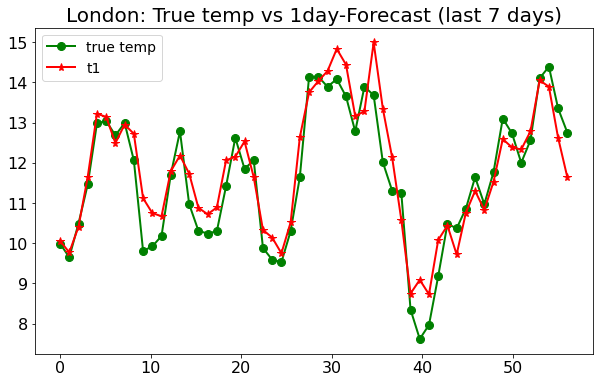

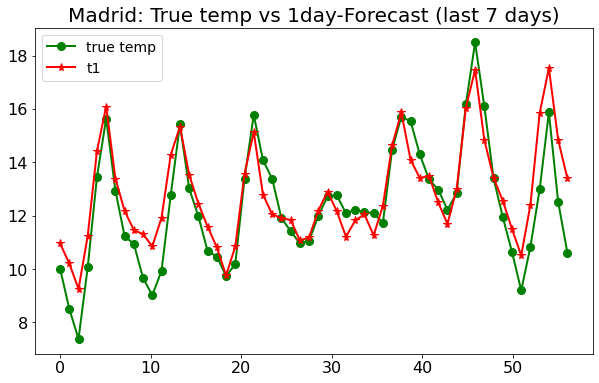

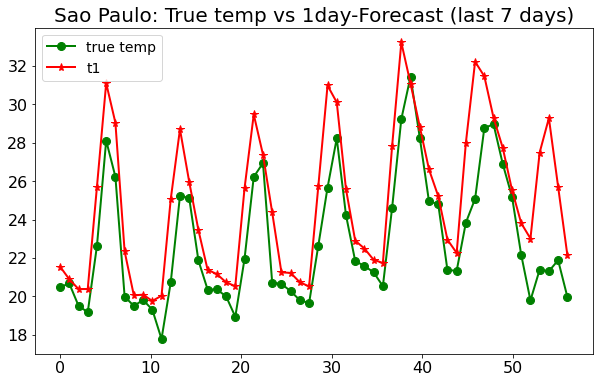

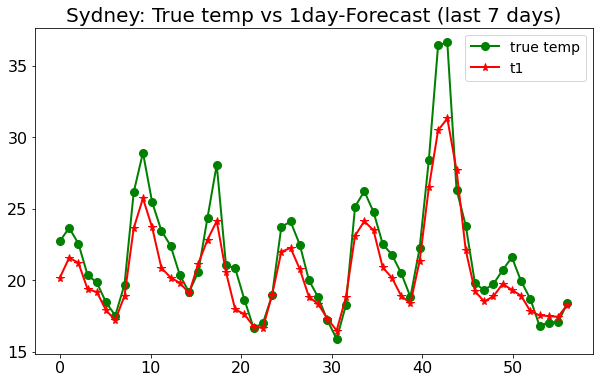

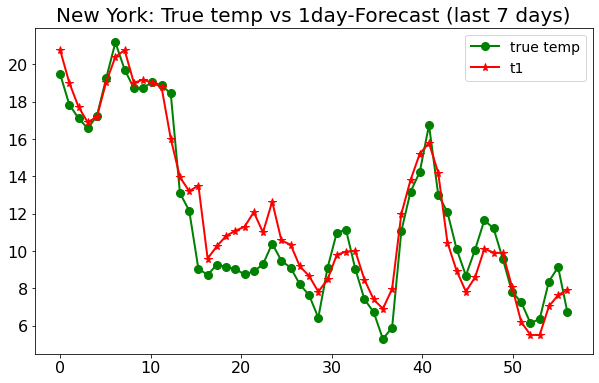

In [10]:
for city in cities:
    plot_true_vs_forecast(city)

## Metrics

In all cases, `medae < rmse < mae`

In [11]:
def plot_metrics(city):
    df = dfs(city)
    # plt.rcParams['figure.figsize'] = (7,3)
    x = np.linspace(0,1,5)
    axes= plt.axes()
#     plt.style.use('classic')
    axes.set_xticks(x)
    axes.set_xticklabels(['t5', 't4', 't3', 't2', 't1'])
    plt.plot(x, df["metrics_df"]['mae'], label='mae', color='blue', marker='o')
    plt.plot(x, df["metrics_df"]['rmse'], label='rmse', color='grey', marker='^')
    plt.plot(x, df["metrics_df"]['medae'], label='medae', color='red', marker='*')
    plt.title(f"metrics - {city_name[city]}")
    plt.legend()
    plt.show()

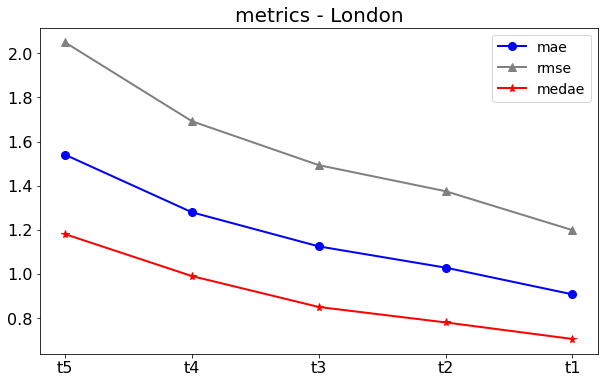

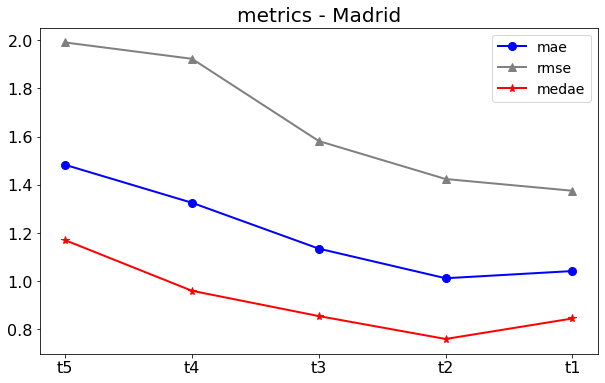

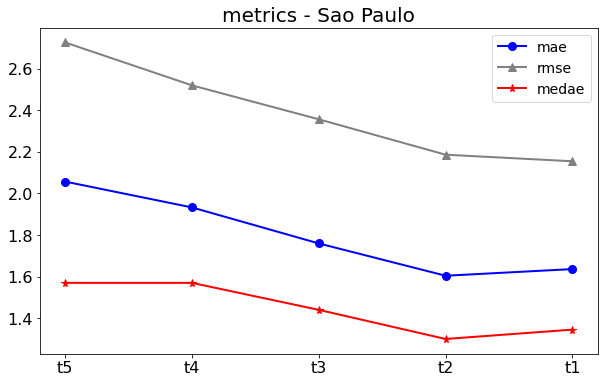

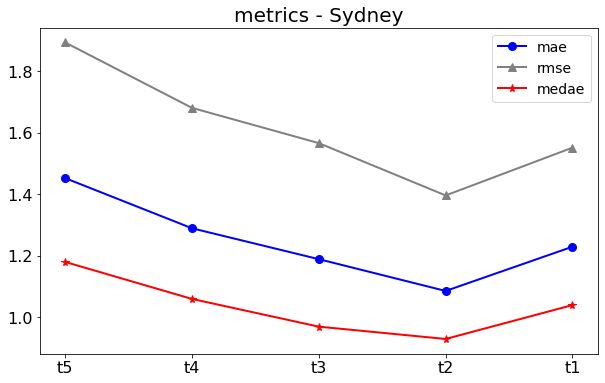

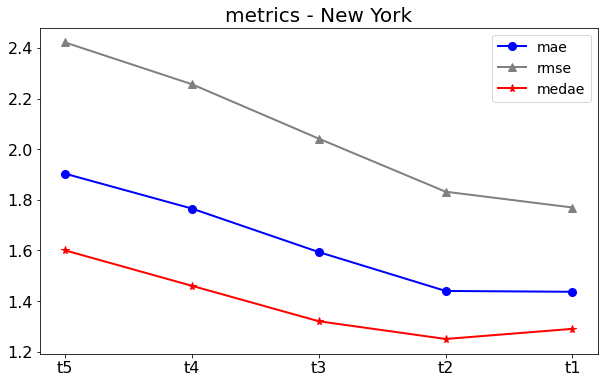

In [12]:
for city in cities:
    plot_metrics(city)

In [13]:
def plot_scaled_error(city):
    df = dfs(city)
    x = np.linspace(0,1,5)
    axes= plt.axes()
    axes.set_xticks(x)
    axes.set_xticklabels(['t5', 't4', 't3', 't2', 't1'])
    plt.plot(x, df["metrics_df"]['mase'], label='mase3h', color='blue', marker='o')
    plt.plot(x, df["metrics_df"]['mase1d'], label='mase1d', color='green', marker='^')
#     plt.plot(x, df["metrics_df"]['mase1y'], label='mase1y', color='red', marker='*')
#     plt.plot(x, df["metrics_df"]['mase1y_avg'], label='mase1y_avg', color='black', marker='o')
    plt.plot(x, np.ones(5), label='1', color='red')
    plt.title(f"Mean Absolute Scaled Error - {city_name[city]}")
    plt.legend()
    plt.show()

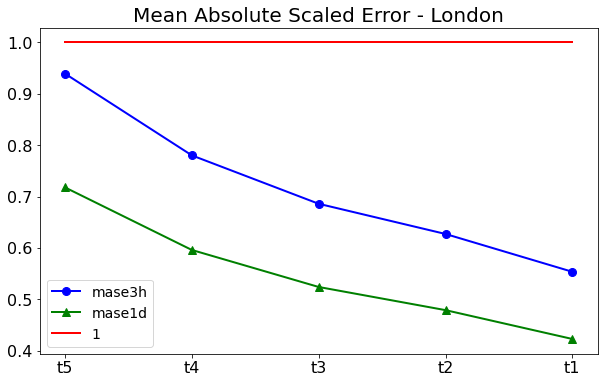

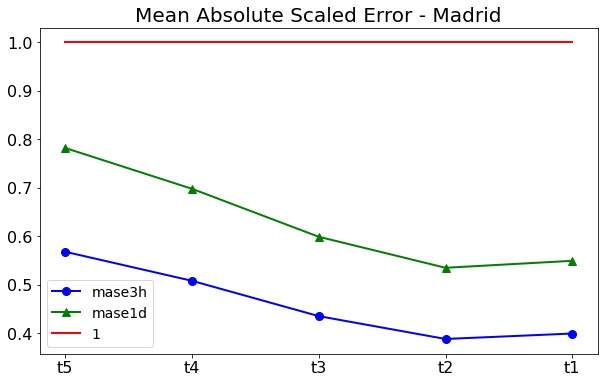

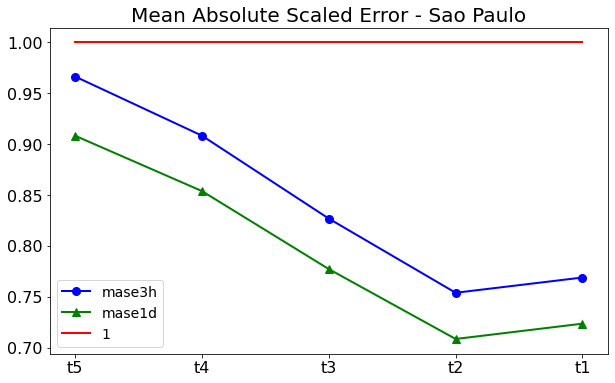

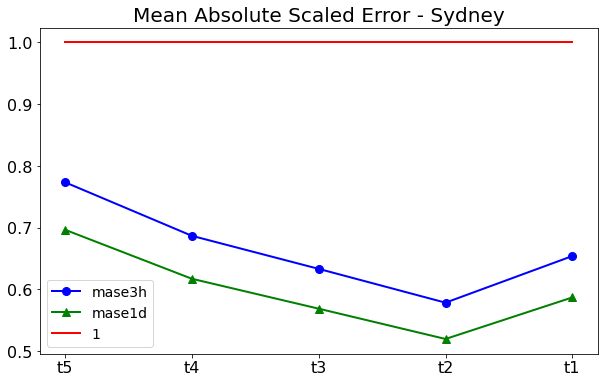

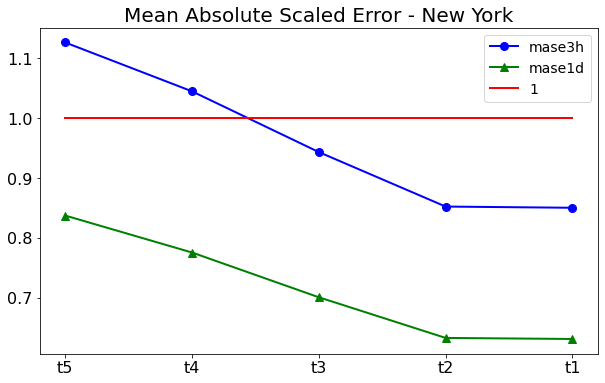

In [14]:
for city in cities:
    plot_scaled_error(city)

In [15]:
def plot_medae():
    # plt.rcParams['figure.figsize'] = (7,3)
    colors = ['blue', 'red', 'green', 'black', 'purple']
    x = np.linspace(0,1,5)
    axes= plt.axes()
    axes.set_xticks(x)
    axes.set_xticklabels(['t5', 't4', 't3', 't2', 't1'])
    for idx, city in enumerate(cities):
        df = dfs(city)    
        plt.plot(x, df["metrics_df"]['medae'], label=city_name[city], color=colors[idx], marker='o')
    plt.title("medae")
    plt.legend()
    plt.show()

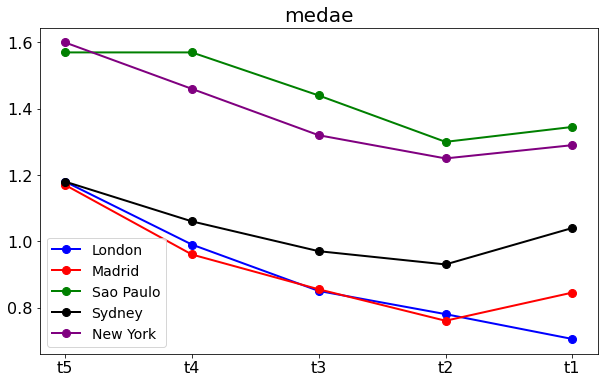

In [16]:
plot_medae()

In [17]:
def plot_mase1d():
    # plt.rcParams['figure.figsize'] = (7,3)
    colors = ['blue', 'red', 'green', 'black', 'purple']
    x = np.linspace(0,1,5)
    axes= plt.axes()
    axes.set_xticks(x)
    axes.set_xticklabels(['t5', 't4', 't3', 't2', 't1'])
    for idx, city in enumerate(cities):
        df = dfs(city)    
        plt.plot(x, df["metrics_df"]['mase1d'], label=city_name[city], color=colors[idx], marker='o')
    plt.plot(x, np.ones(5), label='1', color='grey')
    plt.title("mase1d")
    plt.legend()
    plt.show()

In [18]:
def plot_mase1d_new():
    # plt.rcParams['figure.figsize'] = (7,3)
    colors = ['blue', 'red', 'green', 'black', 'purple']
    x = np.linspace(0,1,5)
    axes= plt.axes()
    axes.set_xticks(x)
    axes.set_xticklabels(cities)
    mase1d = [float(dfs(city)["metrics_df"]['mase1d'].tail(1)) for idx, city in enumerate(cities)]  
    plt.bar(x, mase1d, width=0.1, color='green')
    plt.plot(x, np.ones(5), color='red')
    plt.title("mase1d")
#     plt.legend()
    plt.show()

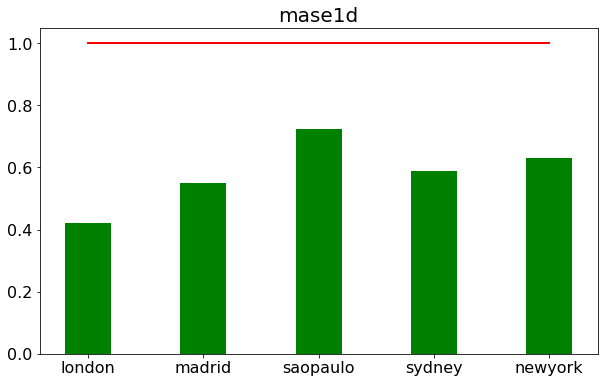

In [19]:
plot_mase1d_new()

<a id="results"></a>
# Results